In [59]:
%matplotlib inline
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi 

## Data Management

In [65]:
data = pd.read_csv('tree_addhealth.csv')

#upper-case all DataFrame column names
data.columns = map(str.upper, data.columns)

# Data Management
data_clean = data.dropna()

In [66]:
# subset clustering variables
cluster=data_clean[['ALCEVR1','MAREVER1','ALCPROBS1','DEVIANT1','VIOL1',
'DEP1','ESTEEM1','SCHCONN1','PARACTV', 'PARPRES','FAMCONCT']]
cluster.describe()

,ALCEVR1,MAREVER1,ALCPROBS1,DEVIANT1,VIOL1,DEP1,ESTEEM1,SCHCONN1,PARACTV,PARPRES,FAMCONCT
count,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000
mean,0.527432,0.241967,0.369180,2.645027,1.618579,8.537049,40.952131,28.360656,6.290710,13.398033,22.570557
std,0.499302,0.428321,0.894947,3.520554,2.593230,6.571052,5.381439,5.156385,3.360219,2.085837,2.614754
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,6.000000,0.000000,3.000000,6.300000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,38.000000,25.000000,4.000000,12.000000,21.700000
50%,1.000000,0.000000,0.000000,1.000000,0.000000,7.000000,40.000000,29.000000,6.000000,14.000000,23.700000
75%,1.000000,0.000000,0.000000,4.000000,2.000000,12.000000,45.000000,32.000000,9.000000,15.000000,24.300000
max,1.000000,1.000000,6.000000,27.000000,19.000000,48.000000,50.000000,38.000000,18.000000,15.000000,25.000000


In [67]:
# standardize clustering variables to have mean=0 and sd=1
scaler = preprocessing.StandardScaler()
cluster_scaled=cluster.copy()
cluster_scaled = pd.DataFrame(scaler.fit_transform(cluster_scaled), columns=cluster_scaled.columns)
cluster_scaled.describe()

,ALCEVR1,MAREVER1,ALCPROBS1,DEVIANT1,VIOL1,DEP1,ESTEEM1,SCHCONN1,PARACTV,PARPRES,FAMCONCT
count,4.575000e+03,4.575000e+03,4.575000e+03,4.575000e+03,4.575000e+03,4.575000e+03,4.575000e+03,4.575000e+03,4.575000e+03,4.575000e+03,4.575000e+03
mean,-8.386734e-17,-2.484958e-17,-3.106198e-18,3.261508e-17,1.553099e-17,-1.304603e-16,3.665313e-16,2.050091e-16,-7.920804e-17,1.638519e-16,-4.659297e-18
std,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00,1.000109e+00
min,-1.056455e+00,-5.649816e-01,-4.125615e-01,-7.513921e-01,-6.242240e-01,-1.299333e+00,-4.265521e+00,-4.336972e+00,-1.872318e+00,-4.985609e+00,-6.223275e+00
25%,-1.056455e+00,-5.649816e-01,-4.125615e-01,-7.513921e-01,-6.242240e-01,-6.905356e-01,-5.486365e-01,-6.518177e-01,-6.817892e-01,-6.703234e-01,-3.329768e-01
50%,9.465623e-01,-5.649816e-01,-4.125615e-01,-4.673149e-01,-6.242240e-01,-2.339378e-01,-1.769481e-01,1.240043e-01,-8.652477e-02,2.886289e-01,4.319970e-01
75%,9.465623e-01,-5.649816e-01,-4.125615e-01,3.849169e-01,1.470994e-01,5.270586e-01,7.522730e-01,7.058709e-01,8.063718e-01,7.681051e-01,6.614892e-01
max,9.465623e-01,1.769969e+00,6.292479e+00,6.918694e+00,6.703348e+00,6.006232e+00,1.681494e+00,1.869604e+00,3.485062e+00,7.681051e-01,9.292300e-01


In [68]:
# split data into train and test sets
clus_train, clus_test = train_test_split(cluster_scaled, test_size=.3, random_state=123)

In [69]:
# k-means cluster analysis for 1-9 clusters                                                           
clusters=range(1,10)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(clus_train)
    clusassign=model.predict(clus_train)
    
    #Y = cdist(XA, XB, 'minkowski', p)
    #Computes the distances using the Minkowski distance ||u−v||p||u−v||p (pp-norm) where p≥1p≥1
    # p = 2 Computes the distance between mm points using Euclidean distance (2-norm) as the distance metric between the points. 
    #The points are arranged as mm nn-dimensional row vectors in the matrix X.
    meandist.append(sum(np.min(cdist(clus_train, model.cluster_centers_, 'minkowski', 2), axis=1)) 
                    / clus_train.shape[0])


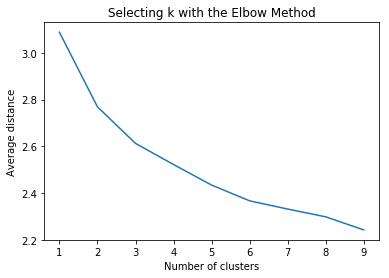

In [70]:
"""
Plot average distance from observations from the cluster centroid
to use the Elbow Method to identify number of clusters to choose
"""

plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')


## Interpret 3 cluster solution

In [71]:
# model3=KMeans(n_clusters=3)
model3.fit(clus_train)
clusassign=model3.predict(clus_train)

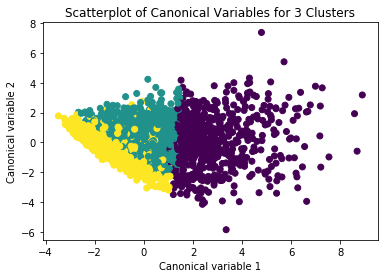

In [72]:
# plot clusters
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(clus_train)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model3.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 3 Clusters')
plt.show()

In [73]:
"""
BEGIN multiple steps to merge cluster assignment with clustering variables to examine
cluster variable means by cluster
"""
# create a unique identifier variable from the index for the 
# cluster training data to merge with the cluster assignment variable
clus_train.reset_index(level=0, inplace=True)
# create a list that has the new index variable
cluslist=list(clus_train['index'])
# create a list of cluster assignments
labels=list(model3.labels_)
# combine index variable list with cluster assignment list into a dictionary
newlist=dict(zip(cluslist, labels))

In [74]:
# convert newlist dictionary to a dataframe
newclus=DataFrame.from_dict(newlist, orient='index')
# rename the cluster assignment column
newclus.columns = ['cluster']
newclus.head()

,cluster
1770,2
575,2
1167,1
3865,1
3347,2


In [75]:
# now do the same for the cluster assignment variable
# create a unique identifier variable from the index for the 
# cluster assignment dataframe to merge with cluster training data
newclus.reset_index(level=0, inplace=True)

# merge the cluster assignment dataframe with the cluster training variable dataframe
# by the index variable
merged_train=pd.merge(clus_train, newclus, on='index')
merged_train.head(n=10)

,index,ALCEVR1,MAREVER1,ALCPROBS1,DEVIANT1,VIOL1,DEP1,ESTEEM1,SCHCONN1,PARACTV,PARPRES,FAMCONCT,cluster
0,1770,-1.056455,-0.564982,-0.412562,-0.751392,-0.624224,-0.994934,-0.176948,0.705871,-0.086525,0.768105,0.546743,2
1,575,-1.056455,-0.564982,-0.412562,0.384917,-0.624224,-0.842735,-1.106169,0.317960,-0.384157,0.768105,0.279002,2
2,1167,0.946562,-0.564982,-0.412562,-0.183238,-0.624224,-0.994934,1.123961,-0.651818,2.294533,0.288629,0.279002,1
3,3865,0.946562,1.769969,-0.412562,-0.467315,-0.624224,-1.147133,1.681494,1.093782,0.211107,0.768105,0.929230,1
4,3347,-1.056455,-0.564982,-0.412562,-0.467315,-0.624224,1.744653,0.008896,-2.009506,0.211107,0.768105,0.546743,2
5,3948,-1.056455,-0.564982,-0.412562,-0.751392,-0.624224,-0.690536,0.938117,1.287737,2.889797,0.288629,0.929230,2
6,568,0.946562,-0.564982,-0.412562,-0.467315,0.532761,2.810048,-1.849546,0.124004,-1.277054,0.768105,-3.392872,0
7,3557,0.946562,1.769969,-0.412562,0.384917,1.689746,0.374859,1.681494,-2.009506,-0.681789,-0.670323,-0.103485,0
8,3885,0.946562,-0.564982,-0.412562,-0.751392,-0.624224,-1.147133,0.380585,1.481693,-0.384157,0.768105,0.814484,1
9,2115,0.946562,-0.564982,1.822452,0.100840,0.147099,0.374859,-0.176948,-0.263907,0.508740,-1.149800,0.546743,1


In [76]:
# cluster frequencies
merged_train.cluster.value_counts()

2    1419
1    1106
0     677
Name: cluster, dtype: int64

## END multiple steps to merge cluster assignment with clustering variables to examine cluster variable means by cluster

In [77]:
# FINALLY calculate clustering variable means by cluster
clustergrp = merged_train.groupby('cluster').mean()
print ("Clustering variable means by cluster")
print(clustergrp)


Clustering variable means by cluster
               index   ALCEVR1  MAREVER1  ALCPROBS1  DEVIANT1     VIOL1  \
cluster                                                                   
0        2323.793205  0.659572  1.080176   0.879917  1.084830  0.781704   
1        2325.872514  0.946562 -0.049857  -0.048816 -0.111833 -0.164638   
2        2264.794221 -1.056455 -0.474480  -0.412562 -0.450899 -0.264110   

             DEP1   ESTEEM1  SCHCONN1   PARACTV   PARPRES  FAMCONCT  
cluster                                                              
0        0.854388 -0.668598 -0.942608 -0.417569 -0.489015 -0.967216  
1       -0.200223  0.196253  0.141892  0.156748  0.110018  0.235393  
2       -0.292501  0.209016  0.342973  0.091971  0.156849  0.299811  


In [78]:
# validate clusters in training data by examining cluster differences in GPA using ANOVA
# first have to merge GPA with clustering variables and cluster assignment data 
gpa_data=data_clean['GPA1']
# split GPA data into train and test sets
gpa_train, gpa_test = train_test_split(gpa_data, test_size=.3, random_state=123)
gpa_train1=pd.DataFrame(gpa_train)
gpa_train1.reset_index(level=0, inplace=True)
merged_train_all=pd.merge(gpa_train1, merged_train, on='index')
sub1 = merged_train_all[['GPA1', 'cluster']].dropna()

In [79]:
gpamod = smf.ols(formula='GPA1 ~ C(cluster)', data=sub1).fit()
print (gpamod.summary())

                            OLS Regression Results                            
Dep. Variable:                   GPA1   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9497
Date:                Sat, 10 Jun 2017   Prob (F-statistic):              0.387
Time:                        05:58:15   Log-Likelihood:                -1847.6
No. Observations:                1587   AIC:                             3701.
Df Residuals:                    1584   BIC:                             3717.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.7780      0.044     

In [80]:
print ('means for GPA by cluster')
m1= sub1.groupby('cluster').mean()
print (m1)

means for GPA by cluster
             GPA1
cluster          
0        2.778042
1        2.827648
2        2.850350


In [81]:
print ('standard deviations for GPA by cluster')
m2= sub1.groupby('cluster').std()
print (m2)

standard deviations for GPA by cluster
             GPA1
cluster          
0        0.764983
1        0.765832
2        0.788254


In [82]:
mc1 = multi.MultiComparison(sub1['GPA1'], sub1['cluster'])
res1 = mc1.tukeyhsd()
print(res1.summary())


Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.0496  -0.0787 0.1779 False 
  0      2     0.0723  -0.0508 0.1954 False 
  1      2     0.0227  -0.0802 0.1256 False 
--------------------------------------------
